# CISC451/893 Competition 1

**TEAM:**<br>
Ryan Elliott - 05999293<br>
Sizhe Guan 20090459<br>
Vishal Chotara 20307118
## Question 3<br>

Assume that each driveway has two cars and that all people work in downtown Kingston, how many new
bus routes are needed to make people leave their cars at home? How much would that reduce the gas
emissions (make your own reasonable assumptions)?

In [5]:
!!pip install -r requirements.txt

['Requirement already satisfied: geopandas in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 1)) (0.10.2)',
 'Requirement already satisfied: pandas in /shared-libs/python3.7/py/lib/python3.7/site-packages (from -r requirements.txt (line 2)) (1.2.5)',
 'Requirement already satisfied: numpy in /shared-libs/python3.7/py/lib/python3.7/site-packages (from -r requirements.txt (line 3)) (1.19.5)',
 'Requirement already satisfied: openpyxl in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 4)) (3.0.9)',
 'Requirement already satisfied: xlrd in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 5)) (2.0.1)',
 'Requirement already satisfied: geopy in /root/venv/lib/python3.7/site-packages (from -r requirements.txt (line 6)) (2.2.0)',
 'Requirement already satisfied: pyproj>=2.2.0 in /root/venv/lib/python3.7/site-packages (from geopandas->-r requirements.txt (line 1)) (3.2.1)',
 'Requirement already satisfied: fiona>=1.8 in /share

In [2]:
!! pip install geopy

['Collecting geopy',
 '  Downloading geopy-2.2.0-py3-none-any.whl (118 kB)',
 'Collecting geographiclib<2,>=1.49',
 '  Downloading geographiclib-1.52-py3-none-any.whl (38 kB)',
 'Installing collected packages: geographiclib, geopy',
 'Successfully installed geographiclib-1.52 geopy-2.2.0',
 'WARNING: You are using pip version 20.1.1; however, version 22.0.3 is available.',
 "You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command."]

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geopy.distance
from datetime import time
from scipy.spatial import cKDTree

In [4]:
# Read Kingston map
streetmap = gpd.read_file("landuse.shp")

In [5]:
bus_routes = gpd.read_file("transit-gtfs-routes.geojson")

In [6]:
# Remove empty row
bus_routes = bus_routes[bus_routes.route_id != "999"]

In [7]:
bus_routes.head()

,route_long_name,route_short_name,route_id,route_type,route_color,filename,geometry
0,None,7,7,Bus,8A6F45,gtfs,"MULTILINESTRING ((-76.47791 44.27481, -76.4781..."
1,None,14,14,Bus,C1CD23,gtfs,"MULTILINESTRING ((-76.57294 44.25507, -76.5727..."
2,None,16,16,Bus,B890C2,gtfs,"MULTILINESTRING ((-76.52310 44.26930, -76.5228..."
3,None,501,501,Bus,231F20,gtfs,"MULTILINESTRING ((-76.57215 44.25508, -76.5738..."
4,None,XTRA,XTRA,Bus,000000,gtfs,"MULTILINESTRING ((-76.51013 44.22445, -76.5127..."


#### Point of Interests
For this dataset, we simply use it to visualize its proximity to any given bus stop

In [8]:
poi = gpd.read_file('point-of-interest.geojson')
poi.head()

,address,name,description,poi_id,geometry
0,434 MCEWEN DR,LA SALLE PARK,Park,8506,POINT (-76.57379 44.23264)
1,718 PARKSIDE CRES,PARKSIDE PARKETTE,Parkette,8507,POINT (-76.54738 44.24690)
2,444 KINGSDALE AVE,MEADOWBROOK PARK,Park,8223,POINT (-76.54431 44.24673)
3,2 CARRE RIDOUT SQ,RIDEOUT ROW/CDA,RMC,7393,POINT (-76.46840 44.23418)
4,1060 LEN BIRCHALL WY,AIRPORT - HANGAR 4,Airport Facility,7970,POINT (-76.59437 44.21989)


### Civic Addresses


In [9]:
addresses = gpd.read_file('civic-addresses.geojson')
addresses.head()

,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,municipality,street_body_name,unit_type,neighbourhood,address_number_suffix,postal_code,geometry
0,Pittsburgh,84935,Tuesday,1207 WATERSIDE WAY,Tuesday,WAY,None,1207,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45446 44.27045)
1,Pittsburgh,84940,Tuesday,1187 WATERSIDE WAY,Tuesday,WAY,None,1187,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,K7K 0J1,POINT (-76.45392 44.27012)
2,Pittsburgh,84958,Tuesday,741 HALLOWAY DR,Tuesday,DR,None,741,HALLOWAY DR,None,KINGSTON,HALLOWAY,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45206 44.27174)
3,Pittsburgh,84973,Tuesday,1453 SUMMER ST,Tuesday,ST,None,1453,SUMMER ST,None,KINGSTON,SUMMER,BASE,Greenwood Park / St. Lawrence South,None,<Null>,POINT (-76.45487 44.27112)
4,Loyalist-Cataraqui,85125,Thursday,808 CELESTE DR,Thursday,DR,None,808,CELESTE DR,None,KINGSTON,CELESTE,BASE,Cataraqui North,None,K7P 0P6,POINT (-76.54984 44.26798)


### October Transit Data

In [15]:
transit_df = pd.read_excel('Transit Data - October.xlsx')
transit_df.head()

,Date,Time,Class,Operation,Bus,Route,Latitude,Longitude
0,2017-10-01,1900-01-01 01:43:03,QUEENS,Exact Fare,620,17,44.227860,-76.496938
1,2017-10-01,1900-01-01 01:43:08,QUEENS,Exact Fare,620,17,44.227860,-76.496938
2,2017-10-01,1900-01-01 01:58:13,ADULT,Pass (Multi-ride card),620,17,44.232035,-76.491397
3,2017-10-01,1900-01-01 01:58:25,QUEENS,Exact Fare,620,17,44.232035,-76.491397
4,2017-10-01,1900-01-01 01:58:27,QUEENS,Exact Fare,620,17,44.232035,-76.491397


In [16]:
transit_df['Route'] = transit_df['Route'].astype('category')
transit_df['Bus'] = transit_df['Bus'].astype('category')

In [17]:
transit_df = transit_df[(transit_df['Latitude'] != 0) & (transit_df['Longitude'] != 0)]

In [18]:
transit_df.describe()

,Latitude,Longitude
count,648786.000000,648786.000000
mean,44.459798,-76.671798
std,6.873336,5.960070
min,0.001280,-255.426092
25%,44.227882,-76.533590
50%,44.235697,-76.507990
75%,44.250848,-76.492228
max,255.426092,-3.051285


In [19]:
transit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648786 entries, 0 to 704538
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       648786 non-null  datetime64[ns]
 1   Time       648786 non-null  datetime64[ns]
 2   Class      648786 non-null  object        
 3   Operation  648786 non-null  object        
 4   Bus        648786 non-null  category      
 5   Route      648786 non-null  category      
 6   Latitude   648786 non-null  float64       
 7   Longitude  648786 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(2)
memory usage: 35.9+ MB


Let us assume that most people start work around 7-9 AM. We will get the subset of transit data that corresponds to busses taken in this time.

In [20]:
morning = (transit_df['Time'].dt.time >= time(6, 0, 0)) & (transit_df['Time'].dt.time <= time(9, 0, 0))
morning_df = transit_df.loc[morning]

In [21]:
morning_df

,Date,Time,Class,Operation,Bus,Route,Latitude,Longitude
26,2017-10-01,1900-01-01 06:16:15,QUEENS,Exact Fare,1362,701,44.233568,-76.513785
27,2017-10-01,1900-01-01 06:17:54,Youth,Pass (Multi-ride card),1372,15,44.268682,-76.574195
36,2017-10-01,1900-01-01 07:58:17,QUEENS,Exact Fare,1364,501,44.224442,-76.494645
37,2017-10-01,1900-01-01 07:58:50,ADULT,Pass (Multi-ride card),1479,502,44.231150,-76.484993
38,2017-10-01,1900-01-01 08:01:15,Child,Exact Fare,622,1,44.255167,-76.573063
...,...,...,...,...,...,...,...,...
704309,2017-10-01,1900-01-01 07:47:26,Child,Exact Fare,1368,502,44.258365,-76.563777
704310,2017-10-01,1900-01-01 07:47:28,Child,Exact Fare,1368,502,44.258365,-76.563777
704311,2017-10-01,1900-01-01 07:47:42,ADULT,Exact Fare,942,1,44.272235,-76.478267
704312,2017-10-01,1900-01-01 07:48:23,Youth,Pass (Multi-ride card),1365,501,44.245300,-76.590400


### Bus Stops

In [10]:
stops = gpd.read_file('transit-gtfs-stops.geojson')
stops.head()

,stop_id,stop_name,wheelchair_boarding,geometry
0,S02077,Cataraqui Centre Transfer Point Platform 1,0,POINT (-76.57215 44.25508)
1,00842,O'Connor Drive (east side of Gardiners),0,POINT (-76.56851 44.25971)
2,00841,Norris Court (east side of Gardiners),0,POINT (-76.56862 44.26311)
3,00848,640 Cataraqui Woods Drive (south side),0,POINT (-76.56721 44.26693)
4,00856,1341 Crossfield Avenue (south side),0,POINT (-76.55471 44.26430)


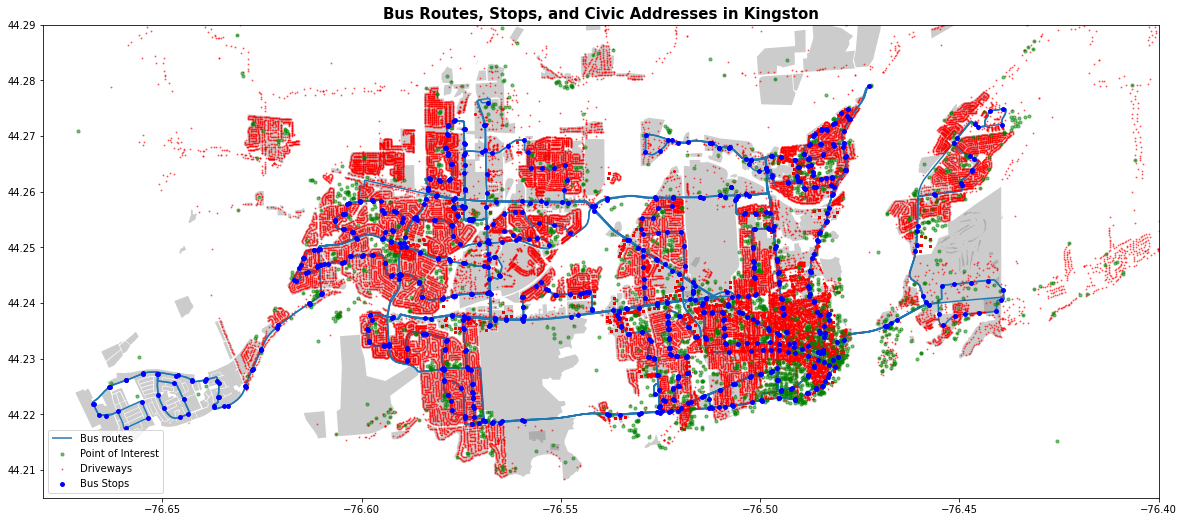

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add bus route shapefile
bus_routes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add POI geodataframe to axes
poi.plot(ax=ax, alpha=0.5, markersize=10, color="green", zorder=2, label="Point of Interest")
# Add driveways geodataframe to axes
addresses.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Driveways")
# Add bus stops geodataframe to axes
stops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
plt.xlim(-76.68,-76.40)
plt.ylim(44.205,44.29)
# Show map
plt.title("Bus Routes, Stops, and Civic Addresses in Kingston", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

Data was not provided for addresses in the bottom left area, where we don't see any red. There are bus stops in that area that are served by bus route 10 which goes along Amherstview up Collins Bay to the Bayridge and Sutton Mills area. It is possible that we can just completely remove those points completely from the addresses dataset but that route also covers some other neighbourhoods that would have to be removed from the addresses dataset. As a result we decided to leave the route as is and note that results involving route 10 would be skewed as its missing a portion of the driveways.

Just from looking at the map, we can see that the bus stops are relatively well distributed across Kingston based on the address density. The lighter red shaded areas have their bus stops distributed inside the neighbourhoods for easy access for everyone there but there are a lower amount of bus stops in those areas. 

Also note that top left and right hand side areas have fewer or no bus stops which would be an issue for those working in downtown.

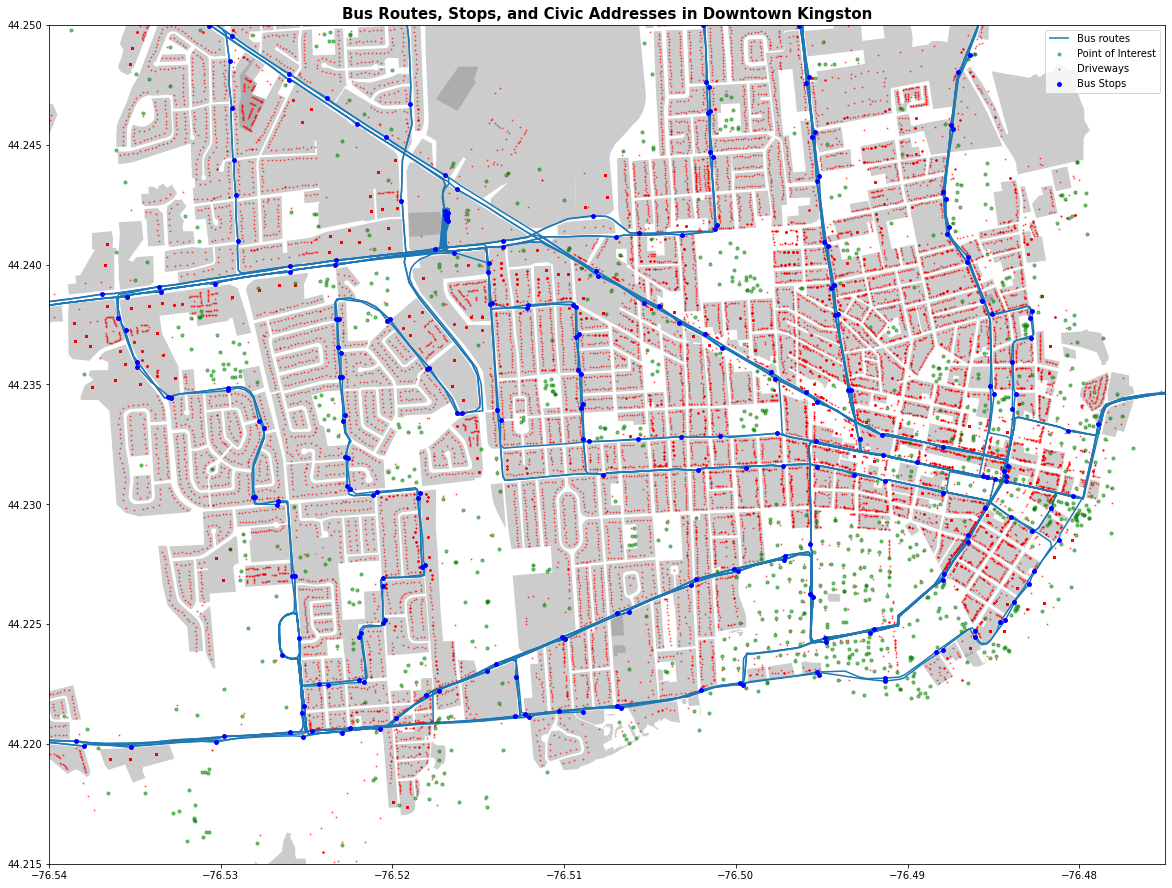

In [14]:
# DOWNTOWN KINGSTON
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add bus route shapefile
bus_routes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add POI geodataframe to axes
poi.plot(ax=ax, alpha=0.5, markersize=10, color="green", zorder=2, label="Point of Interest")
# Add driveways geodataframe to axes
addresses.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Driveways")
# Add bus stops geodataframe to axes
stops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
plt.xlim(-76.54,-76.475)
plt.ylim(44.215,44.25)
# Show map
plt.title("Bus Routes, Stops, and Civic Addresses in Downtown Kingston", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

From this map of Downtown Kingston, we can see that the bus routes are focused around major roads such as Princess street where a lot of the businesses are located. But we also note that towards to top and left side of the map, the neighbour hoods there are relatively far from a bus stop.

### Nearest Stops
Determining the nearest bus stop for each civic address using cKDTree from scipy.spatial package

In [22]:
# need for distance calculation later
addresses['Latitude'] = addresses.geometry.y
addresses['Longitude'] = addresses.geometry.x

stops['s_Latitude'] = stops.geometry.y
stops['s_Longitude'] = stops.geometry.x

In [23]:
def ckdnearest(A, B):
  pA = np.array(list(A.geometry.apply(lambda x: (x.x, x.y))))
  pB = np.array(list(B.geometry.apply(lambda x: (x.x, x.y))))
  btree = cKDTree(pB)
  dist, idx = btree.query(pA, k=1)
  gdf = pd.concat([A.reset_index(drop=True), B.loc[idx, B.columns != 'geometry'].reset_index(drop=True), pd.Series(dist, name='dist')], axis=1)
  return gdf

In [24]:
near_stops = ckdnearest(addresses, stops)
near_stops.head()

,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,municipality,street_body_name,unit_type,neighbourhood,address_number_suffix,postal_code,geometry,Latitude,Longitude,stop_id,stop_name,wheelchair_boarding,s_Latitude,s_Longitude,dist
0,Pittsburgh,84935,Tuesday,1207 WATERSIDE WAY,Tuesday,WAY,None,1207,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45446 44.27045),44.270452,-76.454460,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.003602
1,Pittsburgh,84940,Tuesday,1187 WATERSIDE WAY,Tuesday,WAY,None,1187,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,K7K 0J1,POINT (-76.45392 44.27012),44.270124,-76.453916,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.002968
2,Pittsburgh,84958,Tuesday,741 HALLOWAY DR,Tuesday,DR,None,741,HALLOWAY DR,None,KINGSTON,HALLOWAY,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45206 44.27174),44.271739,-76.452059,09234,Waterside Way (west side of Highway 15),0,44.26972,-76.45062,0.002479
3,Pittsburgh,84973,Tuesday,1453 SUMMER ST,Tuesday,ST,None,1453,SUMMER ST,None,KINGSTON,SUMMER,BASE,Greenwood Park / St. Lawrence South,None,<Null>,POINT (-76.45487 44.27112),44.271122,-76.454869,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.004294
4,Loyalist-Cataraqui,85125,Thursday,808 CELESTE DR,Thursday,DR,None,808,CELESTE DR,None,KINGSTON,CELESTE,BASE,Cataraqui North,None,K7P 0P6,POINT (-76.54984 44.26798),44.267984,-76.549840,09075,Crossfield Avenue (west side of Andersen),0,44.26475,-76.54892,0.003363


We now know the closest bus stop to each address but the distance provided does not translate to real world distance.  So we will use Vincenty distance from geopy.distance package to find distance to bus stops in KM

In [25]:
def distance_to_stop(sample):
  coord1 = (sample.Latitude, sample.Longitude)
  coord2 = (sample.s_Latitude, sample.s_Longitude)
  return geopy.distance.vincenty(coord1, coord2).km

In [26]:
near_stops['distance(km)'] = near_stops.apply(lambda sample: distance_to_stop(sample), axis=1)
near_stops.head()

,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,municipality,street_body_name,unit_type,neighbourhood,address_number_suffix,postal_code,geometry,Latitude,Longitude,stop_id,stop_name,wheelchair_boarding,s_Latitude,s_Longitude,dist,distance(km)
0,Pittsburgh,84935,Tuesday,1207 WATERSIDE WAY,Tuesday,WAY,None,1207,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45446 44.27045),44.270452,-76.454460,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.003602,0.315301
1,Pittsburgh,84940,Tuesday,1187 WATERSIDE WAY,Tuesday,WAY,None,1187,WATERSIDE WAY,None,KINGSTON,WATERSIDE,BASE,Greenwood Park / St. Lawrence South,None,K7K 0J1,POINT (-76.45392 44.27012),44.270124,-76.453916,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.002968,0.258738
2,Pittsburgh,84958,Tuesday,741 HALLOWAY DR,Tuesday,DR,None,741,HALLOWAY DR,None,KINGSTON,HALLOWAY,BASE,Greenwood Park / St. Lawrence South,None,None,POINT (-76.45206 44.27174),44.271739,-76.452059,09234,Waterside Way (west side of Highway 15),0,44.26972,-76.45062,0.002479,0.252045
3,Pittsburgh,84973,Tuesday,1453 SUMMER ST,Tuesday,ST,None,1453,SUMMER ST,None,KINGSTON,SUMMER,BASE,Greenwood Park / St. Lawrence South,None,<Null>,POINT (-76.45487 44.27112),44.271122,-76.454869,09241,Rose Abbey Drive (east side of Highway 15),0,44.26878,-76.45127,0.004294,0.387657
4,Loyalist-Cataraqui,85125,Thursday,808 CELESTE DR,Thursday,DR,None,808,CELESTE DR,None,KINGSTON,CELESTE,BASE,Cataraqui North,None,K7P 0P6,POINT (-76.54984 44.26798),44.267984,-76.549840,09075,Crossfield Avenue (west side of Andersen),0,44.26475,-76.54892,0.003363,0.366812


In [27]:
# descriptives of distance between addresses and stops
near_stops['distance(km)'].describe()


count    69237.000000
mean         0.667581
std          2.173292
min          0.005361
25%          0.084209
50%          0.146294
75%          0.261681
max         26.277336
Name: distance(km), dtype: float64

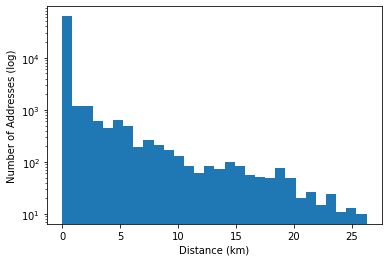

In [28]:
plt.hist(near_stops['distance(km)'], log=True, bins=30)
plt.xlabel("Distance (km)")
plt.ylabel("Number of Addresses (log)")
plt.show()

We can see that the average closest distance to a bus stop is 0.67 KM with a max distance of 26.28 KM and a minimum of 0.005 KM. The histogram shows a high positve skew, showing us that the majority of addresses are really close to a bus stop. Addresses that are over for e.g. 5 - 10KM would most likely be those that were located in neighbourhoods that are far away from the city. These people would be most likely to use a car to travel to work.

### Finding how many routes to consider
Next we look at addresses that are at least 2 KM from a bus stop. We choose 2 KM based on the standard deviation (rounded down).

In [50]:
# the next two cells find addresses that are more than 2KM from a bus stop 
stops_more_than_2km = near_stops.loc[near_stops['distance(km)'] >= 2]
ids = stops_more_than_2km['address_id'].to_list()
stops_more_than_2km.head()


,electoral_district_name,address_id,garbage_day,full_address,recycling_day,street_type_suffix,unit,address_number,street,direction_suffix,municipality,street_body_name,unit_type,neighbourhood,address_number_suffix,postal_code,geometry,Latitude,Longitude,stop_id,stop_name,wheelchair_boarding,s_Latitude,s_Longitude,dist,distance(km)
12,Countryside,20483,Tuesday,1726 MARIAN CRES,Tuesday,CRES,None,1726,MARIAN CRES,None,KINGSTON,MARIAN,BASE,Kingston Mills,None,K7L 5H6,POINT (-76.42667 44.29858),44.298577,-76.426666,00752,933 John Marks Avenue (north side),0,44.27489,-76.43906,0.026733,2.811810
37,Countryside,8589,Tuesday,2562 FINDLAY STATION RD,Tuesday,RD,None,2562,FINDLAY STATION RD,None,KINGSTON,FINDLAY STATION,BASE,Joyceville / Brewer's Mills,None,K0H 1Y0,POINT (-76.27508 44.34074),44.340741,-76.275080,00752,933 John Marks Avenue (north side),0,44.27489,-76.43906,0.176708,14.991133
47,Loyalist-Cataraqui,76625,Friday,856 WINDERMERE DR,Friday,DR,None,856,WINDERMERE DR,None,KINGSTON,WINDERMERE,BASE,Cataraqui Westbrook,None,K7P 0N5,POINT (-76.62771 44.27357),44.273569,-76.627705,00678,Humberside Drive (west side of Mona),0,44.25500,-76.60663,0.028089,2.662578
48,Loyalist-Cataraqui,76651,Friday,726 SQUIRREL HILL DR,Friday,DR,None,726,SQUIRREL HILL DR,None,KINGSTON,SQUIRREL HILL,BASE,Cataraqui Westbrook,None,K7P 0N4,POINT (-76.62609 44.27253),44.272535,-76.626093,00678,Humberside Drive (west side of Mona),0,44.25500,-76.60663,0.026197,2.492317
51,Countryside,77854,Thursday,500 MAPLE LAWN DR,Thursday,DR,None,500,MAPLE LAWN DR,None,KINGSTON,MAPLE LAWN,BASE,Glenburnie,None,K0H 1S0,POINT (-76.46064 44.30225),44.302250,-76.460644,Smspr1,Montreal Street Park and Ride,0,44.27897,-76.47257,0.026157,2.756380


In [51]:
# getting addresses that are >2KM from the nearest bus stop
address_2_km_stop = addresses[addresses['address_id'].isin(ids)]
address_2_km_stop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4928 entries, 12 to 69217
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   electoral_district_name  4918 non-null   object  
 1   address_id               4928 non-null   int64   
 2   garbage_day              4917 non-null   object  
 3   full_address             4928 non-null   object  
 4   recycling_day            4917 non-null   object  
 5   street_type_suffix       4928 non-null   object  
 6   unit                     93 non-null     object  
 7   address_number           4928 non-null   int64   
 8   street                   4928 non-null   object  
 9   direction_suffix         1 non-null      object  
 10  municipality             4928 non-null   object  
 11  street_body_name         4928 non-null   object  
 12  unit_type                4928 non-null   object  
 13  neighbourhood            4918 non-null   object  
 14

Plotting which addresses are >= 10km away from bus stops

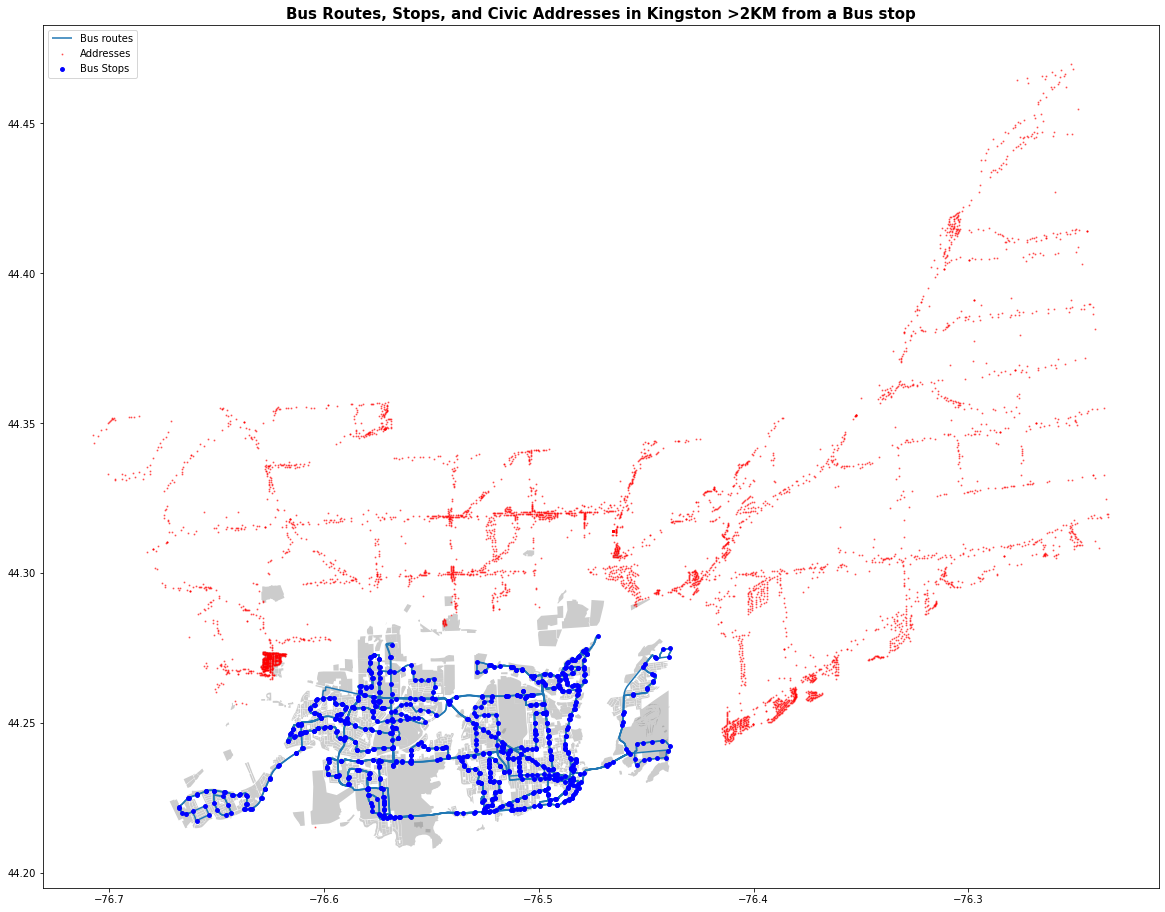

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add bus route shapefile
bus_routes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add addresses geodataframe to axes
address_2_km_stop.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Addresses")
# Add bus stops geodataframe to axes
stops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
# Show map
plt.title("Bus Routes, Stops, and Civic Addresses in Kingston >2KM from a Bus stop", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

One thing to note here is that this plot shows addresses that are at least 2 KM away from a bus stop. What this is telling us that the majority of houses are near a bus stop that can be considered walking distance (< 2KM), and those that are not in this assumed walking distance live in the countryside of Kingston. Realistically it does not make sense for a city to have a bus route go out to the country side that would only take a few passengers, the gas cost to cover the countryside outweigh having a bus route in those areas. 

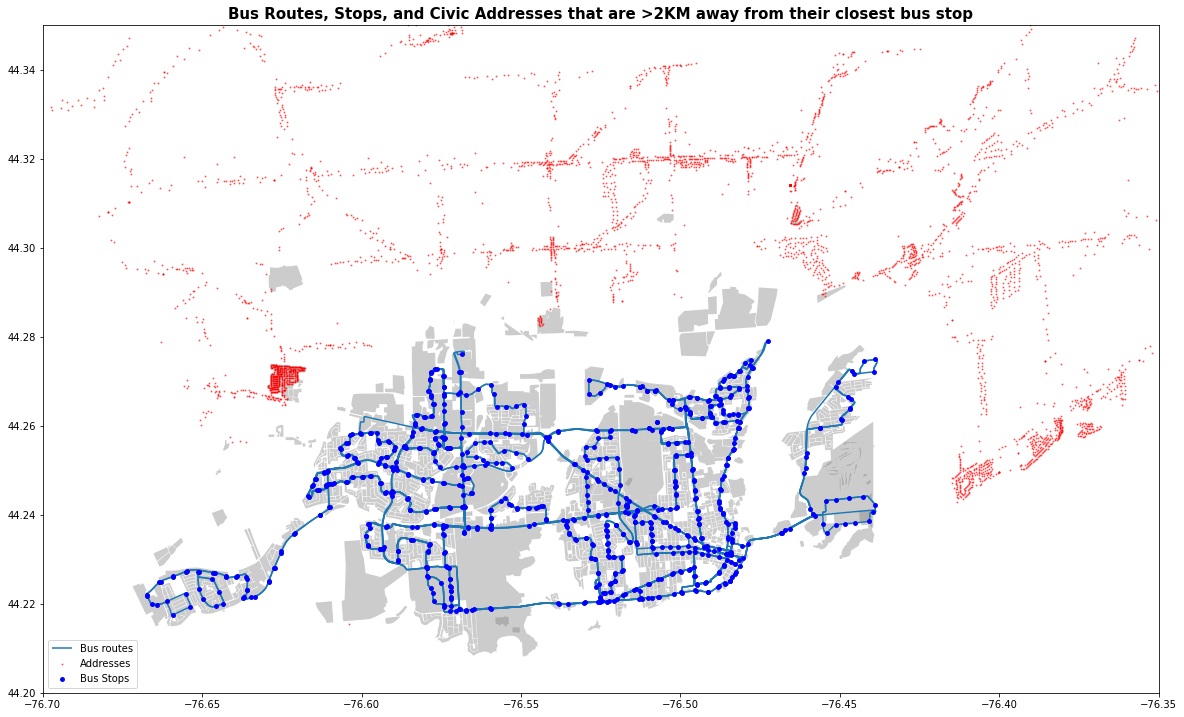

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add bus route shapefile
bus_routes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add addresses geodataframe to axes
address_2_km_stop.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Addresses")
# Add bus stops geodataframe to axes
stops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
# Show map
plt.xlim(-76.7,-76.35)
plt.ylim(44.2,44.35)
plt.title("Bus Routes, Stops, and Civic Addresses that are >2KM away from their closest bus stop", fontsize=15, fontweight="bold")
ax.legend()
plt.show()

For the sake of this question, from this plot we can identify 2-3 areas that could have a bus route towards them to get them to downtown. The first one would be at the dense red section in the top left of the plot, this would be the ideal place to introduce a new route. The two next places to consider would be the top middle and right side of the plot, two routes for each area would be able to cover it. It also may be possible to consider extending already existing routes.

In [54]:
# Finding the number of addresses that are >2KM away from a bus stop
number_of_addresses = address_2_km_stop.shape[0]

In [111]:
# finding all unique stop ids
unique_stops = np.sort(stops_more_than_2km['stop_id'].unique())
unique_stops

array(['00026', '00075', '00089', '00105', '00145', '00531', '00623',
       '00645', '00646', '00667', '00668', '00669', '00678', '00726',
       '00728', '00752', '00797', '00814', '00827', '00828', '00829',
       '02019', '09061', '09075', '09081', '09102', '09239', 'S00028',
       'S00712', 'S00818', 'S02080', 'Smspr1'], dtype=object)

In [112]:
# finding number of addresses that are 2km away from a bus stop and the bus stops ids
address_count_per_stop_over_2km = stops_more_than_2km.groupby(['stop_id'])['address_id'].count()
address_count_per_stop_over_2km

stop_id
00026        1
00075       34
00089      335
00105        2
00145        1
00531      244
00623      125
00645      180
00646        2
00667        5
00668        2
00669       40
00678      337
00726      313
00728        5
00752     1915
00797       22
00814      177
00827        1
00828       89
00829       10
02019       18
09061        6
09075       18
09081       50
09102       12
09239       49
S00028       5
S00712     286
S00818      22
S02080       5
Smspr1     617
Name: address_id, dtype: int64

In [125]:
# we will take stops that accomodate more than 150 addresses that are more than 2KM away
stops_more_than_150 = unique_stops[address_count_per_stop_over_2km > 150]
stops_more_than_150

array(['00089', '00531', '00645', '00678', '00726', '00752', '00814',
       'S00712', 'Smspr1'], dtype=object)

In [126]:
# get addresses that correspond to stops that accomodate more than 150 addresses that are more than 2KM away
stop_address_dense = near_stops[(near_stops['stop_id'].isin(stops_more_than_150))]
stop_address_dense = stop_address_dense[stop_address_dense['distance(km)'] > 2]
stop_address_dense.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4404 entries, 12 to 69165
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   electoral_district_name  4394 non-null   object  
 1   address_id               4404 non-null   int64   
 2   garbage_day              4393 non-null   object  
 3   full_address             4404 non-null   object  
 4   recycling_day            4393 non-null   object  
 5   street_type_suffix       4404 non-null   object  
 6   unit                     91 non-null     object  
 7   address_number           4404 non-null   int64   
 8   street                   4404 non-null   object  
 9   direction_suffix         1 non-null      object  
 10  municipality             4404 non-null   object  
 11  street_body_name         4404 non-null   object  
 12  unit_type                4404 non-null   object  
 13  neighbourhood            4394 non-null   object  
 14

In [127]:
stops_150 = stops[stops['stop_id'].isin(stops_more_than_150)]

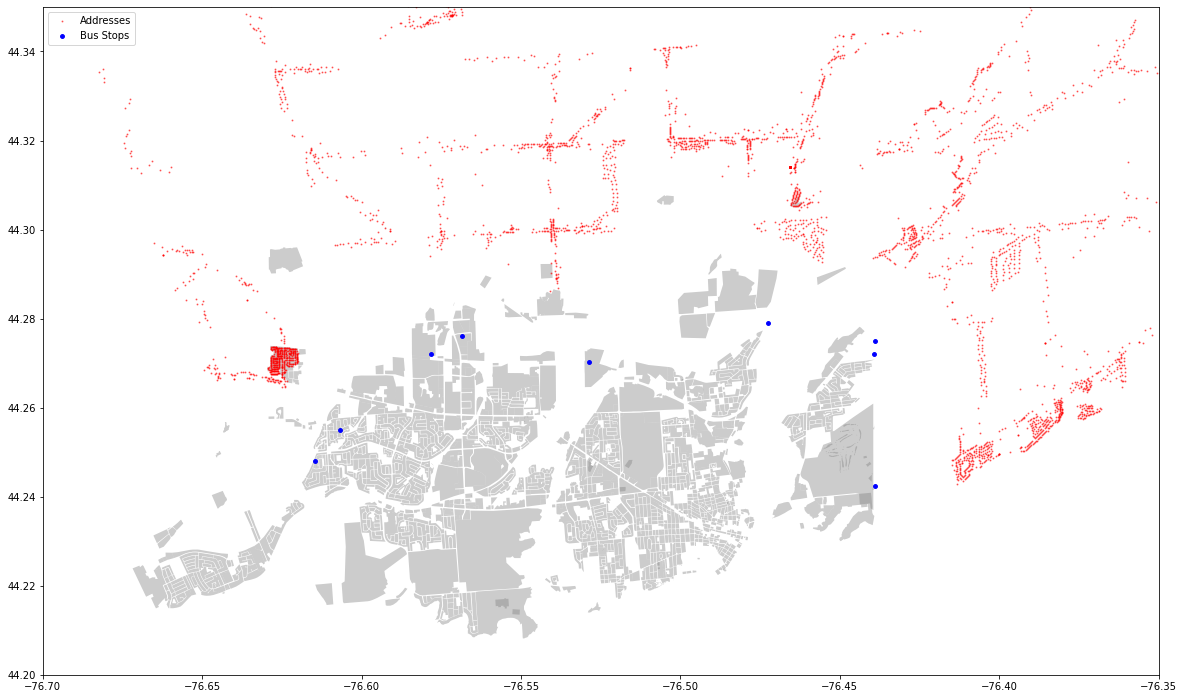

In [128]:
fig, ax = plt.subplots(figsize=(20,20))
# Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
# Add addresses geodataframe to axes
stop_address_dense.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Addresses")
# Add bus stops geodataframe to axes
stops_150.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops')
# Show map
plt.xlim(-76.7,-76.35)
plt.ylim(44.2,44.35)
ax.legend()
plt.show()

**Final answer to main question asked in the beginning:**

The plot above shows bus stops (blue) that correspond to more than 150 addresses. From visual inspection at the bus routes, the following routes serve these bus stops: 10, 7, 15, 16, 801, 601, 12. This plot allows us to see that **3-4 new routes** can be added to extend outwards towards the more dense regions (left of plot, right of plot and top of plot). We have to keep in mind that the grey areas in the plot show the city/developed side of Kingston and that everything farther than that are either newer neighbourhoods or the countryside.



There are 4404 addresses that are more than 2 KM away from their closest bus stop. If we make the simple assumption that each address/driveway will have 2 cars that used by the owners everyday to get to downtown, and that the [average personal vehicle emissions in Canada is 206.0 g CO2/km, as of 2017](https://www.cer-rec.gc.ca/en/data-analysis/energy-markets/market-snapshots/2019/market-snapshot-how-does-canada-rank-in-terms-vehicle-fuel-economy.html), we can say that **4404 * 2 * 206.0 g CO2/km would be reduced per year** (very simple assumption for the sake of calculation). 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba3a38b4-573b-4649-8117-71de8550c212' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>